**CDKM Ripple Carry Adder - DELAY EFFECT:**


1. Import libraries, define backend & define main variables:

In [108]:
# Import libraries
import quantumaudio
from quantumaudio.tools import test_signal, plot
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import CDKMRippleCarryAdder
from qiskit_aer import AerSimulator
import numpy as np

# Define backend
backend = AerSimulator(method='statevector')

# Define main variables
delay = 1

2. Define functions to be used throughout the notebook:

In [109]:
# Function that applies x gates to the time qubits to introduce a delay
def delay_x_gates(delay, num_samples, time_delta, encoded_circuit):
    if delay > num_samples:
        raise ValueError("Number of steps too big")
    else:
        delay_bin = format(delay, 'b') # convert delay to binary
        #print(delay_bin)
        delay_bin = delay_bin[::-1] # invert the binary string to match qubit indexing
        #print(delay_bin)
        for i, bit in enumerate(delay_bin):
                #print(i, bit)
                if bit == '1':
                    encoded_circuit.x(time_delta[i])

# Function that computes the amount of ancilla time qubits needed (delta time qubits)                 
def how_many_dt_qubits(delay, time_qubits):
    howmany = (delay).bit_length() # number of bits needed to represent delay
    delay_bin = format(delay, 'b') # binary representation of delay
    return howmany, delay_bin

3. Generate signal and encode it:

In [110]:
# Define amplitude and time registers
time_qubits = 3  # number of qubits used to represent the time
amp_qubits = 3  # number of qubits used to represent the amplitude
time_reg = QuantumRegister(time_qubits, 'time')  # time register
amp_reg = QuantumRegister(amp_qubits, 'amp')  # amplitude register

# Compute number of samples based on the number of qubits used to represent the time
num_samples = 2**time_qubits

# Import test signal
signal = test_signal(num_channels=1, num_samples=num_samples)
signal = np.array([0.9,0,0,0,0,0,0,0]) # handcrafted signal
scheme = quantumaudio.load_scheme('qsm', qubit_depth=amp_qubits)  # load the QSM scheme
encoding = scheme.encode(signal, verbose=0, measure=False)

# Create the encoded circuit
encoded_circuit = QuantumCircuit()
encoded_circuit.add_register(amp_reg)
encoded_circuit.add_register(time_reg)
encoded_circuit.compose(encoding, inplace=True)
# print("\nEncoded Circuit:")
# encoded_circuit.draw(output='mpl')

Quantum State Modulation


4. Delay effect:

Ancillae qubits: 4
Total qubits: 10
Number of steps to delay the signal: 1
Number of delta time qubits: 1

Encoded Circuit with Delay & Measurements:


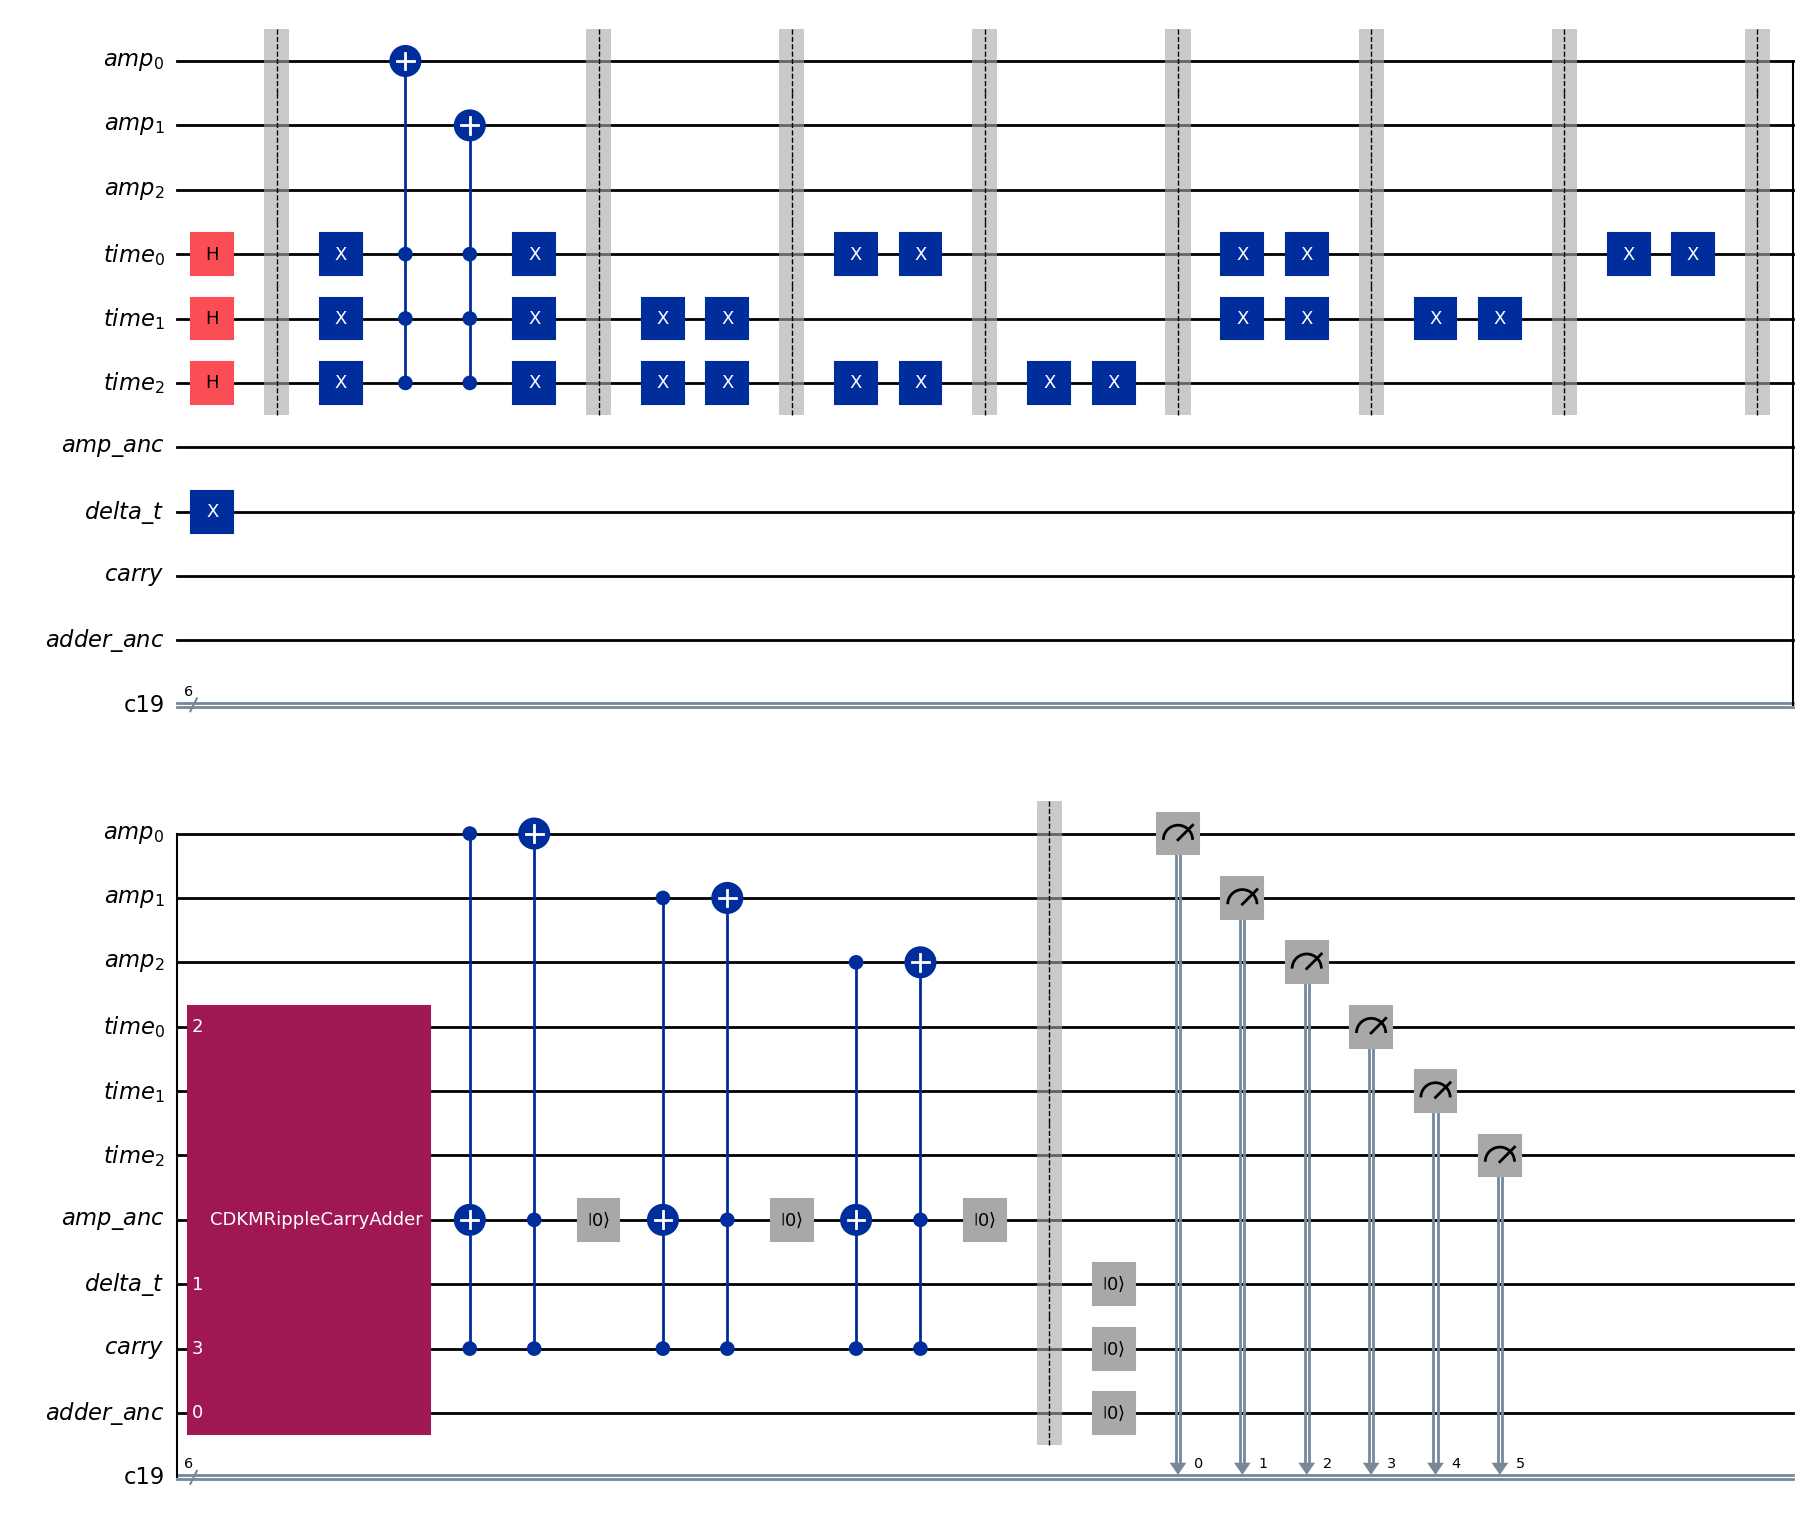

In [111]:
# --- ADD ANCILLAE QUBITS ---
# Compute the number of steps to delay the signal
howmany,delay_bin = how_many_dt_qubits(delay, time_qubits)
# Compute the number of ancillae qubits
ancillae_qubits = 1 + howmany + 2 # amplitude ancilla + time intervals + carry + adder ancilla
print("Ancillae qubits:", ancillae_qubits)
# Compute the total number of qubits
total_qubits = time_qubits + amp_qubits + ancillae_qubits # total number of qubits
print("Total qubits:", total_qubits)
print("Number of steps to delay the signal:", delay)
print("Number of delta time qubits:", howmany)

# Define the ancillae registers
amp_anc = QuantumRegister(1, name='amp_anc')
time_delta = QuantumRegister(howmany, name='delta_t')
carry = QuantumRegister(1, name='carry')
add_anc = QuantumRegister(1, name='adder_anc')

# Add ancillae qubits to the circuit
encoded_circuit.add_register(amp_anc) # add amplitude ancillae
encoded_circuit.add_register(time_delta) # add time intervals
encoded_circuit.add_register(carry) # carry qubit
encoded_circuit.add_register(add_anc) # add adder ancilla

# --- DELAY: TIME ADDER CIRCUIT ---
# Apply x gates to the time qubits to introduce a delay
delay_x_gates(delay, num_samples, time_delta, encoded_circuit)

# TIME CDKM RIPPLE CARRY ADDER CIRCUIT
# Initialize the CDK Ripple Carry Adder circuit
cdk_adder = CDKMRippleCarryAdder(len(time_delta), kind = 'full')
encoded_circuit.append(cdk_adder, add_anc[:]+time_delta[:]+time_reg[:len(time_delta)]+carry[:])

# --- DELAY: SETTING AMPLITUDES THAT GO TO ZERO ---
# Define the target pairs for the ccx gates
target_pairs = []
for i in range(amp_qubits):
    target_pairs.append((amp_reg[i], amp_anc[0]))
    target_pairs.append((amp_anc[0], amp_reg[i]))

    
# Apply the ccx operations in a loop
index = 1
for ctrl2, target in target_pairs:
    encoded_circuit.ccx(carry, ctrl2, target)
    if index % 2 == 0:
        encoded_circuit.reset(amp_anc[0])
    index += 1
encoded_circuit.barrier()

# --- MEASUREMENTS ---
num_measurements = time_qubits + amp_qubits  # we want to measure the first amp and time qubits
if encoded_circuit.num_clbits < num_measurements:
    encoded_circuit.add_register(ClassicalRegister(num_measurements - encoded_circuit.num_clbits))
# Measure only the first n+m qubits
encoded_circuit.reset(time_delta[:]+carry[:]+add_anc[:])
encoded_circuit.measure(range(num_measurements), range(num_measurements)) # ([quantum register], [classical register])

print("\nEncoded Circuit with Delay & Measurements:")
encoded_circuit.draw(output='mpl')

5. Decoded signal and plot comparison:


Original Signal:
[0.9 0.  0.  0.  0.  0.  0.  0. ]

Decoded Signal:
[0.   0.75 0.   0.   0.   0.   0.   0.  ]

Plot:


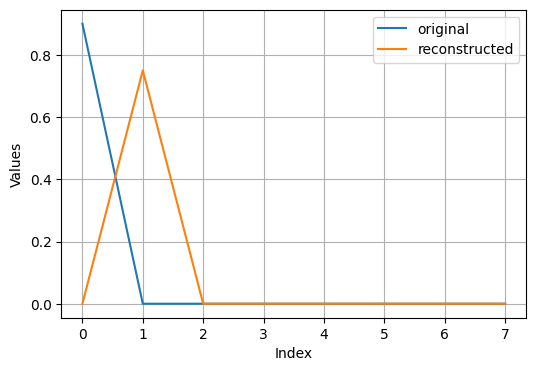

In [112]:
decoded_signal = scheme.decode(encoded_circuit, metadata={'qubit_shape':(time_qubits, amp_qubits),'num_samples':2**time_qubits}, backend=backend)

print("\nOriginal Signal:") 
print(signal)
print("\nDecoded Signal:")
print(decoded_signal)
print("\nPlot:")
plot([signal, decoded_signal])